# Joint-RPCA Introduction

This tutorial builds upon the RPCA tutorial and explains how you can perform RPCA across multiple omics or sources of information shared across samples. If you would like to better understand RPCA please first complete that tutorial first. In this tutorial we will use Joint-RPCA, which we provide in the software package [gemelli](https://github.com/biocore/gemelli), that can account for multiple information sources, compositionality, and sparsity in different types of omics data.

In this tutorial we use _gemelli_ to perform Joint-RPCA on 16S, 18S, and ITS data comparing the surface environment of households across a gradient of urbanization in South America published in [Ruiz-Calderon, Cavallin, and Song et al](https://www.science.org/doi/10.1126/sciadv.1501061). First we will download the processed data originally from [here](https://qiita.ucsd.edu/study/description/10333#). This data can be downloaded with the following links:

* **16S Table** (16S-table.qza) | [download](https://github.com/biocore/gemelli/tree/master/ipynb/tutorials/multi-omics-10333/16S-table.biom)
* **18S Table** (18S-table.qza) | [download](https://github.com/biocore/gemelli/tree/master/ipynb/tutorials/multi-omics-10333/18S-table.biom)
* **ITS Table** (ITS-table.qza) | [download](https://github.com/biocore/gemelli/tree/master/ipynb/tutorials/multi-omics-10333/ITS-table.biom)
* **Sample Metadata** (metadata.tsv) | [download](https://github.com/biocore/gemelli/tree/master/ipynb/tutorials/multi-omics-10333/metadata.tsv)


**Note**: This tutorial assumes you have installed [Qurro](https://github.com/biocore/qurro) and [gemelli](https://github.com/biocore/gemelli).

First, we will make a tutorial directory and download the data above and move the files to the `multi-omics-10333` directory:

```bash
mkdir multi-omics-10333
```



In order to explore how the features across the multiple omics types separate jointly across the samples, we will use Joint-RPCA. Joint-RPCA, builds upon the ability to account for compositionality and sparsity using the robust center log-ratio transform covered in the RPCA tutorial (found [here](https://forum.qiime2.org/t/robust-aitchison-pca-beta-diversity-with-deicode)) but does so with a joint sample factorization across omics. Here we will run Joint-RPCA through _gemelli_ and explore/interpret the different results. 

To run Joint-RPCA we only need to run one command (gemelli joint-rpca). The only required input requirements is:

1. table(s)
    - The input is a list of at least one table(s) of type `FeatureTable[Frequency]` which is a table where the rows are features (e.g. ASVs/microbes/metabolites/genes/genomes), the columns are samples, and the entries are the values for each sample-feature pair. The samples across all input tables must be shared, if samples are not shared they will be automatically removed and a warning will be printed. If there are no shared samples across all tables then Joint-RPCA will exit and error. 

However, there are a few highly recommended optional inputs which allows the user to specify the `train` and `test` labels to be used for cross-validation of the factorization. For examples of how to create your own train/test labels see [here[(https://scikit-learn.org/stable/modules/classes.html#splitter-classes), it is recommended for Joint-RPCA to have  at least 10 test samples. This allows the results to be more robust and reproducible. These inputs are:

2. sample-metadata
    - This is a QIIME2 formatted [metadata](https://docs.qiime2.org/2020.2/tutorials/metadata/) (e.g. tsv format) where the rows are samples. The metadata must have all the samples in the input tables (if there are more than in the input they will be removed and a warning will be given). The use of the sample metadata is to provide training and testing labels, which must be a column in the metadata.

3. train-test-column
    - Sample metadata column containing `train` and `test` labels to use for the cross-validation evaluation.

If the `train` & `test` labels are not specified then `n-test-samples` can be used which will choose a number of random samples to choose for test split samples.

The other important parameters are --p-n-components and --p-max-iterations. 

4. n-components
    - The number of components to use (i.e. the rank). gemelli relies on a low-rank assumption and therefore it is recommended to choose a value between 2 and 10. 

5. max-iterations
    - The number of iterations should be such that the cross-validation input hits a plateau of minimization but does not start increasing. If the cross-validation has not yet hit a stable minimum, for at least a few iterations, it indicates the model may be under fit and the number of iterations should be increased. If the cross-validation hits a stable minimization and then starts increasing again, it indicates an over fit model, and the number of iterations should be decreased. 
    
There are three other helpful parameters that allow you to filter the tables. The most applicable to bieng broadly applied to multiple tables is `min-feature-frequency`, with a recommended range between 0 to 10,  which can improve the cross-validation. By default, all of these parameters are set to zero.   

1. min-sample-count
    -  Minimum sum cutoff of sample across all features. The value can be at minimum zero and must be an whole integer. It is suggested to be greater than or equal to 500.
    
2. min-feature-count
    - Minimum sum cutoff of features across all samples. The value can be at minimum zero and must be an whole integer.
    
3. **min-feature-frequency**
    - Minimum percentage of samples a feature must appear with a value greater than zero. This value can range from 0 to 100 with decimal values allowed.
    
**Note:** it is _not_ recommended to bin your features by assignments (i.e. by genus level). 

Now that we understand the acceptable parameters, we are ready to run Joint-RPCA.  


In [51]:
# importing data
import copy
import pandas as pd
from biom import load_table
from skbio import OrdinationResults, DistanceMatrix

# joint rpca
from gemelli.rpca import (joint_rpca, feature_correlation_table)
from gemelli.utils import filter_ordination

# stats
from skbio.stats.distance import permanova

# plotting data
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

In [19]:
# CLI command 
!gemelli joint-rpca \
    --in-biom multi-omics-10333/16S-table.biom \
    --in-biom multi-omics-10333/18S-table.biom \
    --in-biom multi-omics-10333/ITS-table.biom \
    --sample-metadata-file multi-omics-10333/metadata.tsv \
    --train-test-column  'train_test' \
    --max-iterations 15 \
    --min-feature-frequency 5 \
    --output-dir multi-omics-10333/results/jrpca-cli-output\

!ls multi-omics-10333/results/jrpca-cli-output/*


/Users/cmartino/Dropbox/bin/gemelli/gemelli/preprocessing.py:418: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))
/Users/cmartino/Dropbox/bin/gemelli/gemelli/rpca.py:902: RuntimeWarning: Removing 0 features(s) in table(s) but not the ordination.
  % (unshared_N), RuntimeWarning)
multi-omics-10333/results/jrpca-cli-output/cross-validation-error.tsv
multi-omics-10333/results/jrpca-cli-output/joint-distance-matrix.tsv
multi-omics-10333/results/jrpca-cli-output/joint-ordination.txt


In [23]:
# API command

# import tables
table_16S = load_table('multi-omics-10333/16S-table.biom')
table_18S = load_table('multi-omics-10333/18S-table.biom')
table_ITS = load_table('multi-omics-10333/ITS-table.biom')
# import metadata
metadata = pd.read_csv('multi-omics-10333/metadata.tsv', sep='\t', index_col=0)
metadata.head(2)


,ac_sampled_room,accult_score,analysis_name,animals_in_house,anonymized_name,carbon_dioxide_inside,cats,cleaning_frequency,closed_trash,collection_date,...,temp_inside_house,temp_outside_house,title,use_soaps,village,water_source,wind_speed_outside,years_house_inhabited,zone,train_test
sample_name,,,,,,,,,,,,,,,,,,,,,
10333.Iqu.959.bedr,not provided,26,Iqu.959.bedr,0,MG.0850,not provided,0,daily,not provided,7/18/12,...,NaN,NaN,Dominguez Sloan SAWesternization gradient,NaN,Iquitos,municipal,NaN,5.0,Centro,train
10333.Man.1767.bath,FALSE,30,Man.1767.bath,4,MG.1035,not provided,4,7,TRUE,9/5/12,...,NaN,NaN,Dominguez Sloan SAWesternization gradient,NaN,Manaus,municipal,NaN,15.0,Aleixo,train


In [27]:
ordination, distances, cv_error = joint_rpca([table_16S, table_18S, table_ITS],
                                             sample_metadata  = metadata,
                                             train_test_column = 'train_test',
                                             max_iterations = 15,
                                             min_feature_frequency = 5)


We will now cover the output files:
    * biplot
    * distance_matrix
    * cross_validation_error

one by one.


First, we will explore the `cross-validation-error` to ensure we have a good fit. We expect the CV-error to converge to a minimum and then stop. If there are too many iterations the CV-error will start increasing and if the CV-error does not stay at a minimum value for at least a few iterations it indicates an under fit model, and the iterations should be increased.

We can now plot in matplotlib by both mean and by error (between input tables). 


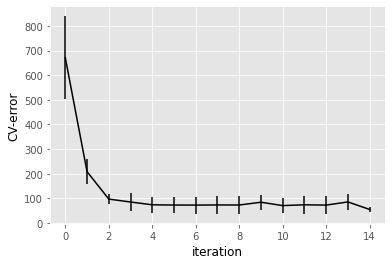

In [29]:
# plot with matplotlib
# can import from file 'multi-omics-10333/results/jrpca-cli-output/cross-validation-error.tsv'
# or just use cv_error  (API)
#df_plt = pd.read_csv('multi-omics-10333/results/jrpca-cli-output/cross-validation-error.tsv',
#                     sep='\t', index_col=0)
plt.errorbar(x=cv_error['iteration'], 
             y=cv_error['mean_CV'], 
             yerr=cv_error['std_CV'],
             c='black')
plt.ylabel('CV-error', color='black')
plt.xlabel('iteration', color='black')
plt.show()

As we can see here we minimize to a point and then stop, this is a good CV curve and we can continue with the exploration of the results. 

Now that we have our ordination file, with type (PCoAResults % Properties(['biplot'])), we are ready to visualize the results. To effectively use the ordination we will color the samples by Village, which was found to separate the samples in the original publication. 


/Users/cmartino/miniconda3/envs/qiime2-2021.2.songbird.mmvec/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


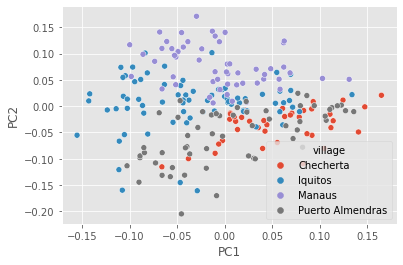

In [70]:
# can import ordination from file or just use ordination (API)
# ordination = OrdinationResults.read('multi-omics-10333/results/jrpca-cli-output/joint-ordination.txt')

ordination_plot = pd.concat([ordination.samples, metadata], axis=1) # merge metdata and ordination to plot
# plot
sns.scatterplot(x='PC1', y='PC2', hue='village', data=ordination_plot)
plt.show()



From this visualization we noticed that Village does seem to explain the clusters well along PC1, jointly across the omics. We can run [PERMANOVA](https://docs.qiime2.org/2019.1/plugins/available/diversity/beta-group-significance/) on the distances to get a statistical significance for this. 

In [37]:
permanova(distances, metadata.loc(axis=0)[distances.ids]['village'])

method name               PERMANOVA
test statistic name        pseudo-F
sample size                     226
number of groups                  4
test statistic              29.6311
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object

We can see from the biplot and PERMANOVA results that the surface samples jointly separate samples significantly across all the omics. Next, the true power of the tool is the ability to pull out the features across each omics that all jointly follow the same direction in the biplot ordination (the arrows). To do this we can use [qurro](https://github.com/biocore/qurro) to explore log-ratios of the microbes highlighted by gemelli. For more about why log-ratios are useful you may want to read ["Establishing microbial composition measurement standards with reference frames"](https://www.nature.com/articles/s41467-019-10656-5).

First, we need to filter the joint ordination back to each omic for qurro.

In [54]:
# CLI command
!gemelli filter-ordination \
    --in-ordination multi-omics-10333/results/jrpca-cli-output/joint-ordination.txt \
    --in-biom multi-omics-10333/16S-table.biom \
    --output-dir multi-omics-10333/results/jrpca-cli-output/matched-16S-ordination

!gemelli filter-ordination \
    --in-ordination multi-omics-10333/results/jrpca-cli-output/joint-ordination.txt \
    --in-biom multi-omics-10333/18S-table.biom \
    --output-dir multi-omics-10333/results/jrpca-cli-output/matched-18S-ordination

!gemelli filter-ordination \
    --in-ordination multi-omics-10333/results/jrpca-cli-output/joint-ordination.txt \
    --in-biom multi-omics-10333/ITS-table.biom \
    --output-dir multi-omics-10333/results/jrpca-cli-output/matched-ITS-ordination

!ls  multi-omics-10333/results/jrpca-cli-output/matched-*/*

multi-omics-10333/results/jrpca-cli-output/matched-16S-ordination/subset-ordination.txt
multi-omics-10333/results/jrpca-cli-output/matched-18S-ordination/subset-ordination.txt
multi-omics-10333/results/jrpca-cli-output/matched-ITS-ordination/subset-ordination.txt


In [53]:
# API command
ordination_16S = filter_ordination(copy.copy(ordination), table_16S)
ordination_18S = filter_ordination(copy.copy(ordination), table_18S)
ordination_ITS = filter_ordination(copy.copy(ordination), table_ITS)


Now we are ready to run Qurro for each omics.


In [62]:
%%capture
# qurro can throw alot of pandas future warnings so I hide them here

!qurro\
    --ranks multi-omics-10333/results/jrpca-cli-output/matched-16S-ordination/subset-ordination.txt\
    --table multi-omics-10333/16S-table.biom \
    --sample-metadata multi-omics-10333/metadata.tsv\
    --output-dir multi-omics-10333/results/jrpca-cli-output/qurro-16S\

!qurro\
    --ranks multi-omics-10333/results/jrpca-cli-output/matched-18S-ordination/subset-ordination.txt\
    --table multi-omics-10333/18S-table.biom \
    --sample-metadata multi-omics-10333/metadata.tsv\
    --output-dir multi-omics-10333/results/jrpca-cli-output/qurro-18S\

!qurro\
    --ranks multi-omics-10333/results/jrpca-cli-output/matched-ITS-ordination/subset-ordination.txt\
    --table multi-omics-10333/ITS-table.biom \
    --sample-metadata multi-omics-10333/metadata.tsv\
    --output-dir multi-omics-10333/results/jrpca-cli-output/qurro-ITS\


In [65]:
# to view them we can open the .html output in the browser
!ls multi-omics-10333/results/jrpca-cli-output/qurro-*

multi-omics-10333/results/jrpca-cli-output/qurro-16S:
icon.png   index.html js         main.js    qurro.css  vendor

multi-omics-10333/results/jrpca-cli-output/qurro-18S:
icon.png   index.html js         main.js    qurro.css  vendor

multi-omics-10333/results/jrpca-cli-output/qurro-ITS:
icon.png   index.html js         main.js    qurro.css  vendor


Now we can explore each result. Instead of grouping by some category like taxonomy, we will just demonstrate the utility of Joint-RPCA by taking the top and bottom rankings along axis one (see the RPCA or Qurro tutorials to see an in depth example). Given the sample clustering along PC1 we expect this ratio to separate the Checherta, Puerto Almendras, and Iquitos/Manus villages. 

**16S**
![image.png](etc/Joint-qurro-16S-1.png)

**18S**
![image.png](etc/joint-qurro-18S-1.png)

**ITS**
![image.png](etc/joint-qurro-ITS-1.png)


In Qurro the axis one loadings (or another axis) from gemelli are highlighted by if they are contained in the numerator or denominator. The log-ratio plot is contained on the left and can be visualized as a scatter or box-plot. Indeed, from these log-ratios, we see that the villages separate as we expect given the biplot ordination. More importantly they all follow the same separation and direction in the log-ratios. In this way Joint-RPCA can allow us to extract the joint information across omics that govern our sample differences. The tsv file can be exported and a t-test by group on the log-ratos could confirm this observation.


![image.png](etc/joint-combined-qurro.png)


An additional functionality of Joint-RPCA is that it can produce a feature by feature correlation table to evaluate the possible relationships between multi-omic features. This can be generated directly from the ordination with the `feature_correlation_table` function. However, it is important to note that the output can be very large in file size because it is all omics features by all omics features and is fully dense. If you would like to get a subset, just subset the ordination with the function `filter_ordination` first. In this case we will just generate the whole table:


In [71]:
# CLI
!gemelli feature-correlation-table \
    --in-ordination multi-omics-10333/results/jrpca-cli-output/joint-ordination.txt \
    --output-dir multi-omics-10333/results/feature-correlation-table \


In [67]:
# API
correlation_table = feature_correlation_table(ordination)


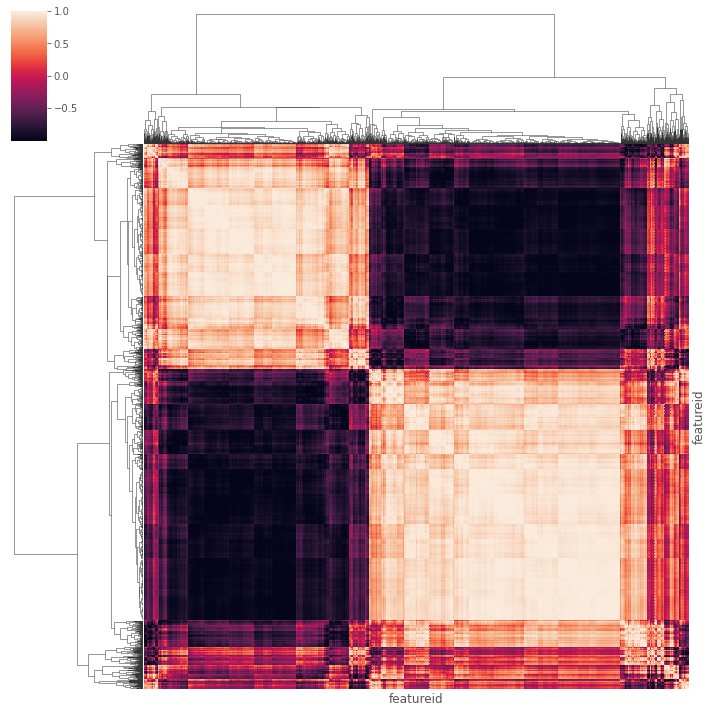

In [68]:
# plot the correlations (Note: this step can take a few minutes)
sns.clustermap(correlation_table,
               yticklabels=False,
               xticklabels=False)

plt.show()


From this correlation table one could also generate networks or simply explore specific multi-omic interactions of interest based on the relationships extracted from the sample groupings above. No matter the methods it is a good idea to verify those interaction with correlations between log-ratios to obtain significance.